In [22]:
pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
from collections import Counter
from pymystem3 import Mystem
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

## Открываем данные

In [24]:
all_data = pd.read_csv('../input/mysberq/vk.csv')

In [25]:
all_data.head()

,Unnamed: 0,question,answer
0,0,кредитная карта моментум. ею можно расплачива...,"вы можете, использовать кредитую карту visa/..."
1,1,"на дебетную карту пришло сообщение о ""неразреш...",по данному вопросу вы можете обратиться в сл...
2,2,вопрос. почему не приходят смс о пополнении ка...,по данному вопросу вы можете обратиться в сл...
3,3,"есть зарплатная карта сб, пользуюсь сбол. кро...",по данному вопросу вы можете обратиться в сл...
4,4,"здраствуйте.мне пришло смс ,что одобрен предво...",потребительский кредит может быть выдан при ...


In [26]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40117 entries, 0 to 40116
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40117 non-null  int64 
 1   question    40082 non-null  object
 2   answer      40115 non-null  object
dtypes: int64(1), object(2)
memory usage: 940.4+ KB


In [27]:
all_data = all_data.dropna()

In [28]:
all_data = all_data.reset_index()
all_data = all_data.drop('index', axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40081 entries, 0 to 40080
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40081 non-null  int64 
 1   question    40081 non-null  object
 2   answer      40081 non-null  object
dtypes: int64(1), object(2)
memory usage: 939.5+ KB


## Строим базовую модель

In [65]:
stopwords_list = stopwords.words('russian')

stopwords_list.extend(['//','http','«\n','»\n','https',"''\n" ])

lemmatizer = Mystem()

def my_tokenizer(doc):
    
    words = word_tokenize(doc)
    pos_tags = pos_tag(words)
    non_stopwords = [w for w in pos_tags if not w[0].lower() in stopwords_list]
    non_punctuation = [w for w in non_stopwords if not w[0] in string.punctuation]
    lemmas = []
    for w in non_punctuation:
  
        lemmas.append(lemmatizer.lemmatize(w[0])[0])

    return lemmas

In [30]:
all_data['lemmas'] = all_data['question'].apply(my_tokenizer)

In [66]:
words = []
for i in all_data['lemmas']:
    words.extend(i)
most_common = Counter(words).most_common()
words, counts = zip(*most_common)
ones = counts.count(1)
most_common = Counter(words).most_common()[:ones]
words, counts = zip(*most_common)
#удалим из словаря все уникальные слова для понижения размерности

In [32]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=my_tokenizer, vocabulary=words) #не берем редкие слова встречающиеся только 1 раз
tfidf_matrix = tfidf_vectorizer.fit_transform(tuple(all_data['question']))
print(tfidf_matrix.shape)

(40081, 12183)


In [33]:
def ask_question(question):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    
    print('Ваш вопрос:', question)
    print('Ближайший вопрос:', all_data.iloc[max_similarity]['question'])
    print('Сходство: {:.2%}'.format(similarity[0, max_similarity]))
    print('Ответ:', all_data.iloc[max_similarity]['answer'])

In [34]:
ask_question('Почему у меня заблокировали карту?')

Ваш вопрос: Почему у меня заблокировали карту?
Ближайший вопрос: заблокировали карту. почему?
Сходство: 100.00%
Ответ:  для уточнения причин блокировки и возможности разблокировки карты рекомендуем вам обратиться в контактный центр по номеру 8-800-555-555-0.


In [35]:
ask_question('Подскажите, а есть ли отделения сбера в Крыму?')

Ваш вопрос: Подскажите, а есть ли отделения сбера в Крыму?
Ближайший вопрос: есть отделения в крыму?
Сходство: 76.87%
Ответ:  в настоящее время группа сбербанк не работает на территории автономной республики крым (ар крым) и города севастополя. решение относительно дальнейших действий пока не принято. в случае каких-либо изменений банк своевременно информирует своих клиентов.


Работает не плохо.) Но мы не можем оценить качество такой модели. И с ней есть много других проблем.

## Кластерный анализ

In [36]:
matrix_df = tfidf_matrix.todense()
matrix_df = pd.DataFrame(matrix_df)

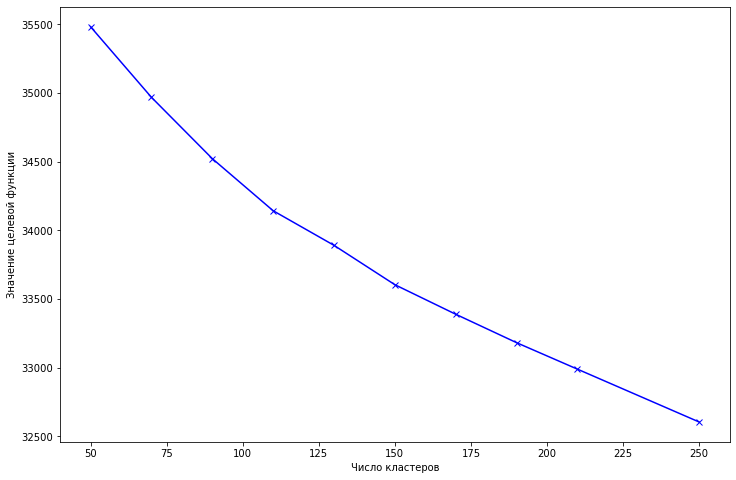

In [37]:

#было ошибкой пытаться это сделать в sklearn. Кластеров много функция не выходит на плато...

"""
%%time

K = (50,250,20)
distortion = []
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(matrix_df)
    print('Число кластеров:', k) 
    print('Значение целевой функции',model.inertia_)
    distortion.append(model.inertia_)
"""  
K = [50,70,90,110,130,150,170,190,210,250]
distortion = [35482.16466495755,34968.55809841195,34522.15676778185,34142.69272324206,33890.75187095296,33604.122521442834, 33389.14892999087, 33182.12732337391,32989.36115059706,32604.70163072907]
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

#Число кластеров: 50
#Значение целевой функции 35482.16466495755
#Число кластеров: 70
#Значение целевой функции 34968.55809841195
#Число кластеров: 90
#Значение целевой функции 34522.15676778185
#Число кластеров: 110
#Значение целевой функции 34142.69272324206
#Число кластеров: 130
#Значение целевой функции 33890.75187095296
#Число кластеров: 150
#Значение целевой функции 33604.122521442834
#Число кластеров: 170
#Значение целевой функции 33389.14892999087
#Число кластеров: 190
#Значение целевой функции 33182.12732337391
#Число кластеров: 210
#Значение целевой функции 32989.36115059706
#Число кластеров: 230
#Значение целевой функции 32761.292596627292

#Число кластеров: 250 
#Значение целевой функции 32604.70163072907


Тут несколько вариантов на данный момент. 1)Искать дальше место где функция  выходит на плато. (на это в данный момент нет времени( 2)Сделать основные вектора-класстеры и обозначить небольшое пространство вокруг каждого из них как кластер, а все остальные значения записать в кластер другое. 3)взять очень примерное число кластров и смириться с повторениями

In [79]:
"""
%%time

# мы берем 250 кластров, потому что не хватает времени довести кластерный анализ до плато..(
model = KMeans(n_clusters=250, random_state=12345)
model.fit(matrix_df)

centroids = pd.DataFrame(model.cluster_centers_, columns=matrix_df.columns)
matrix_df['label'] =  model.labels_.astype(str)
centroids['label'] = [str(i) for i in range(250)]
print('Значение целевой функции',model.inertia_)
data_centroids = pd.concat([matrix_df, centroids], ignore_index=True)
all_data['cluster']=matrix_df['label']
all_data.to_csv('out.csv',index=False)

"""
all_data = pd.read_csv('../input/outsave/out.csv', converters={'lemmas': eval})
all_data['cluster']=all_data['cluster'].astype(str)
matrix_df['label'] = all_data['cluster']


In [39]:
all_data['cluster'].value_counts() #такие вот кластеры по размеру

3      1776
158     629
61      503
166     427
201     374
       ... 
169      20
15       18
161      16
111      16
34       13
Name: cluster, Length: 250, dtype: int64

In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40081 entries, 0 to 40080
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  40081 non-null  int64 
 1   question    40081 non-null  object
 2   answer      40081 non-null  object
 3   lemmas      40081 non-null  object
 4   cluster     40081 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [41]:
def cluster_info(number):
    words = []
    for i in all_data[all_data['cluster']==str(number)]['lemmas']:
        words.extend(i)
    most_common = Counter(words).most_common()[:20]
    return most_common
    
print(cluster_info(161))
clusters_info = {i: cluster_info(i) for i in range(250)} # словарик с инфой по кластерам

[('визит', 17), ('карта', 11), ('банк', 10), ('отделение', 7), ('номер', 5), ('сбербанк', 5), ('мобильный', 4), ('спасибо', 4), ('оформлять', 4), ('привязывать', 3), ('вопрос', 3), ('личный', 3), ('деньги', 3), ('счет', 3), ('офис', 3), ('документ', 3), ('отключать', 2), ('адрес', 2), ('отправлять', 2), ('подсказывать', 2)]


In [42]:
#Попробуем именовать по самому весомому слову в кластере
def cluster_name(number):
    max_word = matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean().max() # самое весомое слово в кластере
    result = np.where(matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean() == max_word)
    result = result[0][0]
    return tfidf_vectorizer.get_feature_names()[result]

cluster_name(161) #неплохо

'визит'

In [43]:
#или по самому весомом относительно других
def cluster_name_two(number):
    mean_total_vecotr = matrix_df.drop('label',axis=1).mean()
    mean_cluster_vector = matrix_df[matrix_df['label']==str(number)].drop('label',axis=1).mean()
    meaning_vector = mean_cluster_vector - mean_total_vecotr
    interesting_value = meaning_vector.max()
    result = np.where(meaning_vector == interesting_value)
    result = result[0][0]   
    return tfidf_vectorizer.get_feature_names()[result]

cluster_name_two(161) # тот же ответ

'визит'

In [44]:
print(cluster_name(3))
print(cluster_name_two(3))

#почти всегда они дают одинаковое значение, но напрмиер 3 кластер:
#сбербанк 
#адрес
#Именователь 2 работает лучше, но дольше

сбербанк
адрес


In [56]:
cluster_info ={str(i): i for i in range(250)}
for i in range(250):
    cluster_info[str(i)]=cluster_name_two(i)
cluster_info

{'0': 'консультация',
 '1': 'ребята',
 '2': 'необходимо',
 '3': 'адрес',
 '4': 'вкладка',
 '5': 'пакет',
 '6': 'страница',
 '7': 'очередь',
 '8': 'перечислять',
 '9': 'поступать',
 '10': 'виртуальный',
 '11': 'ошибка',
 '12': 'мошенник',
 '13': 'новгород',
 '14': 'счет',
 '15': 'реквезит',
 '16': 'платеж',
 '17': 'конец',
 '18': 'подтверждение',
 '19': 'это',
 '20': 'процент',
 '21': 'страхование',
 '22': 'долг',
 '23': 'ипотека',
 '24': 'мошенник',
 '25': 'причина',
 '26': 'снятие',
 '27': 'заказывать',
 '28': 'моментум',
 '29': 'человек',
 '30': 'день',
 '31': 'сбер',
 '32': 'обменять',
 '33': 'потребительский',
 '34': 'максимально',
 '35': 'номер',
 '36': 'один',
 '37': 'акция',
 '38': 'срок',
 '39': 'лимит',
 '40': 'выпуск',
 '41': 'открывать',
 '42': 'сделать',
 '43': 'сколько',
 '44': 'получать',
 '45': 'стоять',
 '46': 'ипотечный',
 '47': 'мир',
 '48': 'рубль',
 '49': 'офис',
 '50': 'зарегистрироваться',
 '51': 'доллар',
 '52': 'клиент',
 '53': 'отвязывать',
 '54': 'льготный',
 

In [46]:
cluster_info = {'0': 'консультация',
 '1': 'ребята',
 '2': 'необходимо',
 '3': 'адрес',
 '4': 'вкладка',
 '5': 'пакет',
 '6': 'страница',
 '7': 'очередь',
 '8': 'перечислять',
 '9': 'поступать',
 '10': 'виртуальный',
 '11': 'ошибка',
 '12': 'мошенник',
 '13': 'новгород',
 '14': 'счет',
 '15': 'реквезит',
 '16': 'платеж',
 '17': 'конец',
 '18': 'подтверждение',
 '19': 'это',
 '20': 'процент',
 '21': 'страхование',
 '22': 'долг',
 '23': 'ипотека',
 '24': 'мошенник',
 '25': 'причина',
 '26': 'снятие',
 '27': 'заказывать',
 '28': 'моментум',
 '29': 'человек',
 '30': 'день',
 '31': 'сбер',
 '32': 'обменять',
 '33': 'потребительский',
 '34': 'максимально',
 '35': 'номер',
 '36': 'один',
 '37': 'акция',
 '38': 'срок',
 '39': 'лимит',
 '40': 'выпуск',
 '41': 'открывать',
 '42': 'сделать',
 '43': 'сколько',
 '44': 'получать',
 '45': 'стоять',
 '46': 'ипотечный',
 '47': 'мир',
 '48': 'рубль',
 '49': 'офис',
 '50': 'зарегистрироваться',
 '51': 'доллар',
 '52': 'клиент',
 '53': 'отвязывать',
 '54': 'льготный',
 '55': 'отклонять',
 '56': 'пенсионный',
 '57': 'заканчиваться',
 '58': 'реквизит',
 '59': 'пин',
 '60': 'комиссия',
 '61': 'кредит',
 '62': 'сей',
 '63': 'документ',
 '64': 'баланс',
 '65': 'коммунальный',
 '66': 'работать',
 '67': 'поменять',
 '68': 'изменять',
 '69': 'обслуживание',
 '70': 'выдавать',
 '71': 'пристав',
 '72': 'мошенница',
 '73': 'восстанавливать',
 '74': 'расчетный',
 '75': 'услуга',
 '76': 'пенсия',
 '77': 'мой',
 '78': 'сутки',
 '79': 'заблокировать',
 '80': '14',
 '81': 'сотрудник',
 '82': 'сб',
 '83': 'стоять',
 '84': 'отделение',
 '85': 'сколька',
 '86': 'обналичивать',
 '87': 'скачать',
 '88': 'заплатить',
 '89': 'идти',
 '90': 'помогать',
 '91': 'средство',
 '92': 'банкомат',
 '93': 'недоступный',
 '94': 'paypal',
 '95': 'перевыпуск',
 '96': 'город',
 '97': 'яндекс',
 '98': 'подавать',
 '99': 'промокод',
 '100': 'автоплатеж',
 '101': 'казахстан',
 '102': '//',
 '103': 'банкомат',
 '104': 'квитанция',
 '105': 'проблема',
 '106': 'промой',
 '107': 'кабинет',
 '108': 'снимать',
 '109': 'отправлять',
 '110': 'паспорт',
 '111': '--\n',
 '112': 'дизайн',
 '113': 'бесплатный',
 '114': 'привязывать',
 '115': 'лист',
 '116': 'вносить',
 '117': 'слово',
 '118': 'бизнес',
 '119': 'привязывать',
 '120': 'оформлять',
 '121': 'год',
 '122': 'поменять',
 '123': 'работа',
 '124': 'переводить',
 '125': 'перевод',
 '126': 'вклад',
 '127': 'временный',
 '128': 'qiwi',
 '129': 'отображаться',
 '130': 'монета',
 '131': 'украина',
 '132': 'пароль',
 '133': 'мобильный',
 '134': 'телефон',
 '135': 'обмен',
 '136': 'momentum',
 '137': 'данна',
 '138': 'маэстро',
 '139': 'одноразовый',
 '140': 'руб',
 '141': 'visa',
 '142': '...',
 '143': 'вклад',
 '144': 'зайти',
 '145': 'место',
 '146': 'зарплата',
 '147': 'смс',
 '148': 'бик',
 '149': 'возврат',
 '150': 'готовый',
 '151': 'крым',
 '152': 'белорусский',
 '153': 'деньги',
 '154': 'работать',
 '155': 'билет',
 '156': '+',
 '157': 'киви',
 '158': "''\n",
 '159': 'полагать',
 '160': 'разблокировать',
 '161': 'визит',
 '162': 'тыс',
 '163': 'овердрафт',
 '164': 'осторожно',
 '165': 'она',
 '166': '//',
 '167': 'семья',
 '168': 'кредитный',
 '169': 'айфон',
 '170': 'ваш',
 '171': 'пароль',
 '172': 'дата',
 '173': 'отвечать',
 '174': 'погашение',
 '175': 'убирать',
 '176': 'евро',
 '177': 'узнавать',
 '178': 'сертификат',
 '179': 'киви',
 '180': '900',
 '181': 'сберегательный',
 '182': 'виза',
 '183': 'сутки',
 '184': 'активировать',
 '185': 'вход',
 '186': 'магазин',
 '187': 'страховка',
 '188': 'оплата',
 '189': 'заявка',
 '190': 'молодежный',
 '191': 'расплачиваться',
 '192': 'получатель',
 '193': 'быть',
 '194': 'входить',
 '195': 'сберкнижка',
 '196': 'новый',
 '197': 'шаблон',
 '198': 'курс',
 '199': 'квартира',
 '200': 'книжка',
 '201': 'карта',
 '202': 'ответ',
 '203': 'украсть',
 '204': 'гражданин',
 '205': 'подключать',
 '206': 'выписка',
 '207': 'севастополь',
 '208': 'электрон',
 '209': 'долго',
 '210': 'арест',
 '211': 'карточка',
 '212': 'какой',
 '213': 'приложение',
 '214': 'тариф',
 '215': 'логин',
 '216': 'classic',
 '217': 'операция',
 '218': 'бонус',
 '219': 'авто',
 '220': 'капитал',
 '221': 'pay',
 '222': 'фамилия',
 '223': 'кредит',
 '224': 'чек',
 '225': 'потерять',
 '226': 'личный',
 '227': 'сообщение',
 '228': 'отключать',
 '229': 'владелец',
 '230': '16',
 '231': 'дата',
 '232': 'претензия',
 '233': 'одобрять',
 '234': 'штраф',
 '235': 'оплачивать',
 '236': 'другой',
 '237': 'ставка',
 '238': 'кто',
 '239': 'вернуть',
 '240': 'подключать',
 '241': 'лицевой',
 '242': 'предложение',
 '243': 'моментальный',
 '244': 'минус',
 '245': 'заявление',
 '246': 'личка',
 '247': 'кредитка',
 '248': '000',
 '249': 'история'}

{'0': 'консультация',
 '1': 'ребята',
 '2': 'необходимо',
 '3': 'адрес',
 '4': 'вкладка',
 '5': 'пакет',
 '6': 'страница',
 '7': 'очередь',
 '8': 'перечислять',
 '9': 'поступать',
 '10': 'виртуальный',
 '11': 'ошибка',
 '12': 'мошенник',
 '13': 'новгород',
 '14': 'счет',
 '15': 'реквезит',
 '16': 'платеж',
 '17': 'конец',
 '18': 'подтверждение',
 '19': 'это',
 '20': 'процент',
 '21': 'страхование',
 '22': 'долг',
 '23': 'ипотека',
 '24': 'мошенник',
 '25': 'причина',
 '26': 'снятие',
 '27': 'заказывать',
 '28': 'моментум',
 '29': 'человек',
 '30': 'день',
 '31': 'сбер',
 '32': 'обменять',
 '33': 'потребительский',
 '34': 'максимально',
 '35': 'номер',
 '36': 'один',
 '37': 'акция',
 '38': 'срок',
 '39': 'лимит',
 '40': 'выпуск',
 '41': 'открывать',
 '42': 'сделать',
 '43': 'сколько',
 '44': 'получать',
 '45': 'стоять',
 '46': 'ипотечный',
 '47': 'мир',
 '48': 'рубль',
 '49': 'офис',
 '50': 'зарегистрироваться',
 '51': 'доллар',
 '52': 'клиент',
 '53': 'отвязывать',
 '54': 'льготный',
 

In [55]:
cluster_indexes ={str(i): i for i in range(250)}

for i in range(250):
    cluster_indexes[str(i)] = all_data[all_data['cluster']==str(i)].index

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [ ]:
#cluster_indexes 
#cluster_info
#all_data
#tfidf_matrix
#tfidf_vectorizer

## Поиск лучших ответов

Будем отвечать на вопросы таким образом: 1) сначала находим самый близакий вопрос и даем на него ответ как делали ранее 2) Находим второй в данных исключая кластер первого ответа 3) Находим третий ответ в данных исключая первые два кластера

Таким образом мы хотим получить достаточно разные вопрос-ответы что-бы охватить релевантные темы.

In [90]:
def ask_question_clusters(question, tfidf_matrix= tfidf_matrix,tfidf_vectorizer=tfidf_vectorizer,silent = False):
    query_vect = tfidf_vectorizer.transform([question])
    similarity = cosine_similarity(query_vect, tfidf_matrix)
    max_similarity = np.argmax(similarity, axis=None)
    cluster_one = all_data.iloc[max_similarity]['cluster']
    max_similarity2 = np.argmax(np.delete(similarity,cluster_indexes.get(cluster_one)), axis=None)
    cluster_two = all_data.iloc[max_similarity2]['cluster']
    max_similarity3 = np.argmax(np.delete(similarity,np.delete(similarity,cluster_indexes.get(cluster_one))), axis=None)
    cluster_three = all_data.iloc[max_similarity3]['cluster']
    
    if silent == False:
        
        print('Ваш вопрос:', question)
        print()
        print('Ближайший вопрос 1:', all_data.iloc[max_similarity]['question'])
        print('Сходство 1: {:.2%}'.format(similarity[0, max_similarity]))
        print('Ответ 1:', all_data.iloc[max_similarity]['answer'])
        print('Кластер 1:', cluster_info.get(cluster_one))
        print()
        print('Ближайший вопрос 2:', all_data.iloc[max_similarity2]['question'])
        print('Сходство 2: {:.2%}'.format(similarity[0, max_similarity2]))
        print('Ответ 2:', all_data.iloc[max_similarity2]['answer'])
        print('Кластер 2:', cluster_info.get(cluster_two))
        print()
        print('Ближайший вопрос 3:', all_data.iloc[max_similarity3]['question'])
        print('Сходство 3: {:.2%}'.format(similarity[0, max_similarity3]))
        print('Ответ 3:', all_data.iloc[max_similarity3]['answer'])
        print('Кластер 3:', cluster_info.get(cluster_three))
    
    return [cluster_one, cluster_two,cluster_three]
    

In [71]:
ask_question_clusters("Как мне разблокировать карту??")

Ваш вопрос: Как мне разблокировать карту??

Ближайший вопрос 1: как разблокировать карту?
Сходство 1: 100.00%
Ответ 1:  для уточнения возможности разблокировки карты рекомендуем вам обратиться в контактный центр банка по бесплатному номеру 8-800-555-555-0.
Кластер 1: разблокировать

Ближайший вопрос 2: а в данный момент я не смогу изменить номер?
Сходство 2: 0.00%
Ответ 2: если номер телефона был изменен, вам необходимо написать заявление в отделении банка на отключение услуги мобильный банк от предыдущего номера и подключить услугу к новому.
Кластер 2: изменять

Ближайший вопрос 3: а можно ли оформить удбо электронной? не посещяя банк ? просто времени ужасно нет, а при оформлении карты мне его забыли оформить
Сходство 3: 2.54%
Ответ 3:  к сожалению, оформление удбо в режиме онлайн не возможно. для его оформления рекомендуем обратиться в офис банка лично.
Кластер 3: оформлять


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


['160', '68', '120']

In [73]:
ask_question_clusters("Подскажите, как можно снять деньги без комиссии в Абхазии?")

Ваш вопрос: Подскажите, как можно снять деньги без комиссии в Абхазии?

Ближайший вопрос 1: есть банкомат в абхазии и какая комиссия?
Сходство 1: 81.78%
Ответ 1:  на территории абхазии нет банкоматов и офисов нашего банка. на территории другой страны наличные по карте нашего банка можно получить в офисах или банкоматах тех банков, которые работают с картами международных платежных систем visa (international) и mastercard (worldwide). возможность получения наличных можно уточнить у сотрудников стороннего банка. за проведение операции снятия наличных в стороннем банке взимается комиссия в соответствии с тарифами нашего банка 1% от суммы, но не менее 100 руб., если операция в банкомате и не менее 150 руб. - в офисе другого банка.  обратите внимание, что сторонний банк также может взимать комиссию за проведение операции по карте, размер которой необходимо уточнить у сотрудника этого банка. напоминаем, что по картам платежной системы visa international к сумме операции добавляется комиссия 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


['60', '112', '119']

## Тестируем модель

In [81]:
train, test = train_test_split(all_data,random_state=123, test_size=0.1)

In [85]:
#для чистоты эксперемента надо полностью обучить модель без тестовых данных в т.ч в словаре
words = []
for i in train['lemmas']:
    words.extend(i)
most_common = Counter(words).most_common()
words, counts = zip(*most_common)
ones = counts.count(1)
most_common = Counter(words).most_common()[:ones]
words, counts = zip(*most_common)

tfidf_vectorizer_train = TfidfVectorizer(tokenizer=my_tokenizer, vocabulary=words) #не берем редкие слова встречающиеся только 1 раз
tfidf_matrix_train = tfidf_vectorizer_train.fit_transform(tuple(train['question']))
print(tfidf_matrix.shape)

(40081, 12183)


In [91]:
ask_question_clusters("Расскажите мне чего ни будь интересное",tfidf_matrix_train,tfidf_vectorizer_train)

Ваш вопрос: Расскажите мне чего ни будь интересное

Ближайший вопрос 1: произошла следующая ситуация: снимались в банкомате с карты деньги, операция по снятию денег с карты прошла успешно, о чем пришло смс, но деньги банкомат не выдал! чека также не было, только вернулась карта. после этого деньги снимались в другом банкомате и таких проблем не было. что делать в данной ситуации?
Сходство 1: 55.10%
Ответ 1:   по данному вопросу вы можете обратиться в службу помощи банка по телефону 8-800-555-55-50 (+7 495 500 5550 - международный номер), чтобы у специалиста была возможность проанализировать информацию и предоставить консультацию. для идентификации и аутентификации у вас может быть запрошена следующая информация по карте: номер карты, фио, контрольная информация, информация о персональных данных, содержащихся в базе данных банка. также вас могут попросить сообщить информацию о некоторых совершенных по карте операциях.
Кластер 1: банкомат

Ближайший вопрос 2: дело в том что конверт утрач

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


['103', '2', '3']

Метрика качества. Если на вопрос из тестовой выборки хотя бы один из трех предложенных кластеров совпадает с реальным кластером мы засчитываем как правильный ответ, в противном случае как ошибку.

(Важно понимать что так мы в большей степени оцениваем качество кластерного анализа, а не самих ответов.)

In [111]:
true_answers = 0

for i in test['question']:
    clusters = ask_question_clusters(i,tfidf_matrix_train,tfidf_vectorizer_train, silent = True)
    if test[test['question']==i]['cluster'].iloc[0] in clusters:
        true_answers +=1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out o

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

Accuracy:  0.02070341731105014


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 

In [116]:
print("Accuracy: ",true_answers/(len(test)))
#Accuracy:  0.02070341731105014 (на 250 кластерах)
print('Random accuracy: ', 1/(250/3))
#Random accuracy:  0.012

Accuracy:  0.02070341731105014
Random accuracy:  0.012


Мы можем сделать вывод что наша модель находит нужный кластер у новых вопросов почти в два раза лучше генератора случайных чисел:). на 250 кластерах

Вместе с тем эти показатели крайне малы, значит кластерный анализ нужно улучшать оптимзируя количество кластеров и для определения кластеров использывать более сложные модели.